In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from pprint import pprint

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_excel('data/data.xlsx')

In [4]:
data.head()

,client_id,loan_currency,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,status_of_loan,location,emirates,gender,age,family_status,monthly_income_aed,quantity_of_prior_loans_at_cbi,employment_sphere,employment_level,work_experience,presence_of_car,presence_of_housing,coborrower,collateral,top_up,dsr
0,4964,AED,174400.0,2020-02-26,2025-02-28,60,0.0549,3,3,10,CAR LOAN,Active,UNITED ARAB EMIRATES,DXB Rigga Road BR,Female,51,MARRIED,78096.43,10,Personal salary,MANAGER,5 Years 0 Months,1,0,No,No,No,NaN
1,5331,AED,100000.0,2021-11-16,2026-11-26,60,0.0300,6,11,9,CAR LOAN,Active,UNITED ARAB EMIRATES,DXB Rigga Road BR,Male,59,MARRIED,204166.66,9,Personal salary,PARTNER,19 Years 1 Months,1,0,No,No,No,NaN
2,5214,AED,180000.0,2021-11-24,2024-12-10,36,0.0457,0,0,0,CAR LOAN,Active,JORDAN,DXB Rigga Road BR,Male,45,MARRIED,15000.00,0,Personal salary,MANAGING DIRECTOR,4 Years 3 Months,1,0,No,No,No,NaN
3,4996,AED,171999.0,2018-11-08,2024-06-26,68,0.0686,6,15,4,CAR LOAN,Active,JORDAN,DXB Rigga Road BR,Male,49,MARRIED,50000.00,4,Personal salary,MANAGER,4 Years -4 Months,1,0,No,No,No,49.21
4,5153,AED,50000.0,2021-12-08,2025-11-27,48,0.0457,0,0,5,CAR LOAN,Active,UNITED ARAB EMIRATES,RAK Julphar BR,Male,56,MARRIED,72167.00,5,Personal (Non business),OTHERS,36 Years 4 Months,4,1,No,No,No,NaN


## Data cleaning and feature selection

In [7]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

data['inflation_rate'] = np.zeros(len(data))
data['manufacturing_PMI'] = np.zeros(len(data))

for i in data.index:
    for j in macro.index:
        if data.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            data.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            data.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [8]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

data['CPI'] = [ np.nan for i in data.index]

for i in data.index:
    for j in macro2.index:
        if data.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and data.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            data.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [9]:
data_macro = data.copy()

---

In [10]:
# Creating target columns #
data_macro['max_90_bad'] = (data_macro['max_dpd_3_year'] >= 90).astype(int)
data_macro['cmltv_90_bad'] = (data_macro['cumulative_days_of_late_payments_throughout_loan_repayments'] >= 90).astype(int)

print(data_macro['cmltv_90_bad'].value_counts())

0    2646
1     543
Name: cmltv_90_bad, dtype: int64


In [60]:
target = 'cmltv_90_bad'

cat_feats = [
    'location',
    'emirates',
    'gender',
    'family_status',
    'employment_sphere',
    'collateral',
    'type_of_product',
    'employment_level'
]
num_feats = [
    'loan_amount',
    'duration_at_disbursement_months',
    'interest_rate',
    'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'age',
    'monthly_income_aed',
    'work_experience',
    'inflation_rate',
    'manufacturing_PMI',
    'presence_of_car',
    'presence_of_housing',
    'CPI'
]

ignore_feats = [
    'client_id',
    'loan_currency',
    'date_of_disbursement',
    'date_of_closure_based_on_contract',
    'max_dpd_3_year',
    'cumulative_days_of_late_payments_throughout_loan_repayments',
    'status_of_loan',
    'quantity_of_prior_loans_at_cbi',
    'coborrower',
    'top_up',
    'dsr',
    'max_90_bad'
]

In [12]:
data_macro.isna().sum()

client_id                                                        0
loan_currency                                                    0
loan_amount                                                      0
date_of_disbursement                                             0
date_of_closure_based_on_contract                                0
duration_at_disbursement_months                                  0
interest_rate                                                    0
max_dpd_3_year                                                   0
cumulative_days_of_late_payments_throughout_loan_repayments      0
quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi       0
type_of_product                                                  0
status_of_loan                                                   0
location                                                         0
emirates                                                         0
gender                                                        

In [13]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in data_macro.index:
    it = data_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    data_macro.at[i, 'work_experience'] = int(years*12 + months)
    
data_macro['work_experience'] = data_macro['work_experience'].astype('float32')

In [14]:
data_macro[data_macro['work_experience'].isna()][['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
85,AED,0.068444,NaN
143,AED,0.080508,NaN
2097,AED,0.045000,NaN
2536,AED,0.120000,NaN


In [15]:
data_macro[['loan_currency', 'interest_rate', 'work_experience']]

,loan_currency,interest_rate,work_experience
0,AED,0.0549,60.0
1,AED,0.0300,229.0
2,AED,0.0457,51.0
3,AED,0.0686,44.0
4,AED,0.0457,436.0
...,...,...,...
3184,AED,0.0750,122.0
3185,AED,0.0600,82.0
3186,AED,0.1150,128.0
3187,AED,0.0550,23.0


In [16]:
data_na = data_macro.dropna(subset=cat_feats+num_feats)

---

In [17]:
# Choosing only Closed loans & Active loans that are already bad #
data_closed_or_bad = data_na[(data_na['status_of_loan'] == 'Active') & (data_na[target] == 1) | (data_na['status_of_loan'] != 'Active')]

In [18]:
data_closed_or_bad.drop(columns=["loan_currency"], inplace=True)

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_closed_or_bad, train_size=0.8, random_state=89, stratify=data_closed_or_bad[target])

In [20]:
# Target mean encoding #
cols = cat_feats

for col in cols:
    stats = train[target].groupby(train[col]).agg(['count', 'mean'])
    train[col+'_mean_encoded'] = train[col].copy()
    test[col+'_mean_encoded'] = test[col].copy()
    
    for i in train[col+'_mean_encoded'].unique():
        train[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)        
        test[col+'_mean_encoded'].replace(i, stats.loc[i]['mean'], inplace=True)

In [21]:
# Removing classes that are in test set but not in train set #
for i in test.index:
    for col in cat_feats:
        if type(test[col+'_mean_encoded'][i]) == str:
            test.drop(i,inplace=True)
            break

In [22]:
# We move all categorical variables to numerical list #
for i in cat_feats:
    num_feats.extend( [i+'_mean_encoded'] )
    ignore_feats.extend([i])

cat_feats.clear()

---

In [23]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)

if sorted(all_columns) == sorted(dataset_columns) :
    print( 'All variables are found in feature lists' )
else :
    print('Features found in dataset but not in lists :')
    for i in dataset_columns :
        if i not in all_columns :
            print(i)
    
    print('-'*50)
    print('Features found in lists but not in dataset')
    for i in all_columns :
        if i not in dataset_columns:
            print(i)

Features found in dataset but not in lists :
--------------------------------------------------
Features found in lists but not in dataset
loan_currency


In [24]:
# CHECK IF ALL COLUMNS ARE USED OR IF THERE IS AN EXTRA COLUMN
all_columns = cat_feats + num_feats + ignore_feats
dataset_columns = list(train.columns)
dataset_columns.remove(target)
sorted(all_columns) == sorted(dataset_columns)

False

# Modeling
---

In [25]:
exp = ClassificationExperiment()
exp.setup(
    data=train,
    test_data=test,
    target=target,
    index=False,
    fold_shuffle=True,
    
    # categorical_imputation='mode',
    # numeric_imputation='mean',
    
    categorical_features=cat_feats,
    numeric_features=num_feats,
    ignore_features=ignore_feats,
    ordinal_features={},

    max_encoding_ohe=70,
    
    remove_multicollinearity=True,
    multicollinearity_threshold=0.85,
    
    use_gpu=False,
    memory=False,
    transformation = True,
    session_id=15,
)

,Description,Value
0,Session id,15
1,Target,cmltv_90_bad
2,Target type,Binary
3,Original data shape,"(2679, 40)"
4,Transformed data shape,"(2679, 20)"
5,Transformed train set shape,"(2152, 20)"
6,Transformed test set shape,"(527, 20)"
7,Ignore features,20
8,Numeric features,20
9,Rows with missing values,1.7%


In [26]:
best = exp.compare_models(sort = 'AUC', include = ['rf', 'gbc', 'catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8397,0.8273,0.3348,0.7189,0.4543,0.3754,0.4141,1.1630
gbc,Gradient Boosting Classifier,0.8373,0.8204,0.3393,0.6982,0.4525,0.3713,0.4063,0.2510
rf,Random Forest Classifier,0.8346,0.7925,0.2841,0.7286,0.4054,0.3313,0.3821,0.2580


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

In [27]:
# train catboost
trained_model_catboost = exp.create_model(
    estimator='catboost',
    iterations=1000,
    learning_rate=0.01,
    fold=5
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8561,0.8136,0.3908,0.7907,0.5231,0.4496,0.4884
1,0.8306,0.8465,0.2759,0.7059,0.3967,0.3195,0.3675
2,0.8535,0.8252,0.3837,0.7674,0.5116,0.4365,0.4729
3,0.8302,0.8488,0.2558,0.7097,0.3761,0.3021,0.3552
4,0.8465,0.8140,0.3563,0.7561,0.4844,0.4076,0.4475
Mean,0.8434,0.8296,0.3325,0.7460,0.4584,0.3831,0.4263
Std,0.0111,0.0153,0.0560,0.0331,0.0605,0.0608,0.0548


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [189]:
calibrated_catboost = exp.calibrate_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.8072,0.3409,0.6818,0.4545,0.3688,0.3998
1,0.8657,0.8262,0.4545,0.8000,0.5797,0.5069,0.5356
2,0.8465,0.8472,0.3256,0.7778,0.4590,0.3866,0.4366
3,0.8093,0.8371,0.2093,0.5625,0.3051,0.2205,0.2570
4,0.8558,0.8491,0.4186,0.7500,0.5373,0.4599,0.4874
5,0.8419,0.8091,0.3721,0.6957,0.4848,0.4014,0.4289
6,0.8326,0.8403,0.2791,0.7059,0.4000,0.3233,0.3706
7,0.8419,0.8392,0.3023,0.7647,0.4333,0.3609,0.4137
8,0.8465,0.8286,0.4186,0.6923,0.5217,0.4369,0.4565


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [29]:
# train gbc
trained_model_gbc = exp.create_model(
    estimator='gbc',
    learning_rate=0.03,
    fold=5
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8445,0.8083,0.2874,0.8333,0.4274,0.3612,0.4303
1,0.8167,0.8103,0.1724,0.6818,0.2752,0.2109,0.2773
2,0.8488,0.8027,0.3023,0.8387,0.4444,0.3786,0.4451
3,0.8302,0.8248,0.2093,0.7826,0.3303,0.2685,0.3462
4,0.8349,0.7985,0.2414,0.8077,0.3717,0.3072,0.3823
Mean,0.8350,0.8089,0.2426,0.7888,0.3698,0.3053,0.3762
Std,0.0113,0.0090,0.0482,0.0571,0.0623,0.0613,0.0606


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [31]:
# train rf
trained_model_rf = exp.create_model(
    estimator='rf',
    fold=5
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8608,0.8035,0.3678,0.8649,0.5161,0.4499,0.5062
1,0.8283,0.7861,0.2759,0.6857,0.3934,0.3140,0.3584
2,0.8395,0.7712,0.3488,0.6977,0.4651,0.3828,0.4147
3,0.8279,0.7895,0.2326,0.7143,0.3509,0.2802,0.3393
4,0.8372,0.8040,0.3103,0.7297,0.4355,0.3580,0.4028
Mean,0.8387,0.7909,0.3071,0.7385,0.4322,0.3570,0.4043
Std,0.0120,0.0122,0.0489,0.0649,0.0570,0.0584,0.0580


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [209]:
# GET PERFORMANCE METRICS:
threshold = 0.3
predictions = exp.predict_model(calibrated_catboost, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8235,0.7893,0.2381,0.6579,0.3497,0.2726,0.3201


{'0': {'precision': 0.8495575221238938,
       'recall': 0.909952606635071,
       'f1-score': 0.8787185354691075,
       'support': 422},
 '1': {'precision': 0.49333333333333335,
       'recall': 0.3523809523809524,
       'f1-score': 0.4111111111111111,
       'support': 105},
 'accuracy': 0.7988614800759013,
 'macro avg': {'precision': 0.6714454277286136,
               'recall': 0.6311667795080117,
               'f1-score': 0.6449148232901093,
               'support': 527},
 'weighted avg': {'precision': 0.7785830632567043,
                  'recall': 0.7988614800759013,
                  'f1-score': 0.7855519708437003,
                  'support': 527},
 'threshold': 0.3,
 'TN': 384,
 'FP': 38,
 'FN': 68,
 'TP': 37,
 'AUC': 0.7893,
 'model NPL': 15.04,
 ' real NPL': 19.92,
 'approval rate': 85.77,
 'good correct': 91.0,
 'bad correct': 35.24}


In [197]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(calibrated_catboost, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8235,0.7893,0.2381,0.6579,0.3497,0.2726,0.3201


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.620493,0.78928,236.0,186.0,14.0,91.0
1,0.15,0.726755,0.78928,314.0,108.0,36.0,69.0
2,0.20,0.760911,0.78928,349.0,73.0,53.0,52.0
3,0.25,0.781784,0.78928,370.0,52.0,63.0,42.0
4,0.30,0.798861,0.78928,384.0,38.0,68.0,37.0


In [35]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(trained_model_gbc, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8159,0.7410,0.1429,0.6818,0.2362,0.1796,0.2522


{'0': {'precision': 0.8609112709832134,
       'recall': 0.8507109004739336,
       'f1-score': 0.8557806912991658,
       'support': 422},
 '1': {'precision': 0.42727272727272725,
       'recall': 0.44761904761904764,
       'f1-score': 0.4372093023255814,
       'support': 105},
 'accuracy': 0.7703984819734345,
 'macro avg': {'precision': 0.6440919991279703,
               'recall': 0.6491649740464907,
               'f1-score': 0.6464949968123737,
               'support': 527},
 'weighted avg': {'precision': 0.7745126996556971,
                  'recall': 0.7703984819734345,
                  'f1-score': 0.7723841147484516,
                  'support': 527},
 'threshold': 0.25,
 'TN': 359,
 'FP': 63,
 'FN': 58,
 'TP': 47,
 'AUC': 0.7409,
 'model NPL': 13.91,
 ' real NPL': 19.92,
 'approval rate': 79.13,
 'good correct': 85.07,
 'bad correct': 44.76}


In [36]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(trained_model_gbc, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8159,0.7410,0.1429,0.6818,0.2362,0.1796,0.2522


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.426945,0.740928,126.0,296.0,6.0,99.0
1,0.15,0.620493,0.740928,255.0,167.0,33.0,72.0
2,0.20,0.702087,0.740928,311.0,111.0,46.0,59.0
3,0.25,0.770398,0.740928,359.0,63.0,58.0,47.0
4,0.30,0.808349,0.740928,388.0,34.0,67.0,38.0


In [37]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(trained_model_rf, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8121,0.7597,0.1714,0.6000,0.2667,0.1954,0.2465


{'0': {'precision': 0.8753315649867374,
       'recall': 0.7819905213270142,
       'f1-score': 0.8260325406758449,
       'support': 422},
 '1': {'precision': 0.38666666666666666,
       'recall': 0.5523809523809524,
       'f1-score': 0.4549019607843137,
       'support': 105},
 'accuracy': 0.7362428842504743,
 'macro avg': {'precision': 0.630999115826702,
               'recall': 0.6671857368539833,
               'f1-score': 0.6404672507300793,
               'support': 527},
 'weighted avg': {'precision': 0.7779694884713533,
                  'recall': 0.7362428842504743,
                  'f1-score': 0.7520881177373044,
                  'support': 527},
 'threshold': 0.25,
 'TN': 330,
 'FP': 92,
 'FN': 47,
 'TP': 58,
 'AUC': 0.7597,
 'model NPL': 12.47,
 ' real NPL': 19.92,
 'approval rate': 71.54,
 'good correct': 78.2,
 'bad correct': 55.24}


In [38]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(trained_model_rf, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8121,0.7597,0.1714,0.6000,0.2667,0.1954,0.2465


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.504744,0.759682,172.0,250.0,11.0,94.0
1,0.15,0.624288,0.759682,248.0,174.0,24.0,81.0
2,0.20,0.702087,0.759682,298.0,124.0,33.0,72.0
3,0.25,0.736243,0.759682,330.0,92.0,47.0,58.0
4,0.30,0.789374,0.759682,369.0,53.0,58.0,47.0


In [39]:
# three_models = exp.blend_models([trained_model_catboost,trained_model_gbc, trained_model_rf])
calibrated_three_models = exp.blend_models([calibrated_catboost,calibrated_gbc, calibrated_rf])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8519,0.7999,0.3636,0.8000,0.5000,0.4271,0.4729
1,0.8657,0.8217,0.4545,0.8000,0.5797,0.5069,0.5356
2,0.8512,0.8280,0.3488,0.7895,0.4839,0.4118,0.4588
3,0.8047,0.8148,0.1628,0.5385,0.2500,0.1732,0.2147
4,0.8558,0.8323,0.3953,0.7727,0.5231,0.4484,0.4834
5,0.8372,0.7839,0.3721,0.6667,0.4776,0.3902,0.4136
6,0.8419,0.8231,0.3023,0.7647,0.4333,0.3609,0.4137
7,0.8372,0.8403,0.2558,0.7857,0.3860,0.3191,0.3864
8,0.8465,0.8211,0.3953,0.7083,0.5075,0.4251,0.4505


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [40]:
# GET PERFORMANCE METRICS:
threshold = 0.25
predictions = exp.predict_model(calibrated_three_models, raw_score=True, encoded_labels=True)
predictions['prediction_label'] = (predictions['prediction_score_1'] > threshold).astype(int)
# predictions.to_excel('predictions.xlsx', index=False)

report         = classification_report(predictions[target], predictions['prediction_label'], output_dict=True)
tn, fp, fn, tp = confusion_matrix(     predictions[target], predictions['prediction_label']).ravel()
auc            = roc_auc_score(        predictions[target], predictions['prediction_score_1'])

report['threshold'] = threshold
report['TN'] = tn
report['FP'] = fp
report['FN'] = fn
report['TP'] = tp
report['AUC'] = round(auc, 4)
report['model NPL'] = round(fn/(tn+fn)*100, 2)
report[' real NPL'] = round(report['1']['support']/(report['1']['support'] + report['0']['support']) * 100, 2)
report['approval rate'] = round((fn + tn)/report['weighted avg']['support']*100, 2)
report['good correct'] = round(tn/(fp+tn)*100, 2)
report['bad correct'] = round(tp/(fn+tp)*100, 2)

pprint(report, sort_dicts=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8178,0.7738,0.2190,0.6216,0.3239,0.2456,0.2906


{'0': {'precision': 0.8632075471698113,
       'recall': 0.8672985781990521,
       'f1-score': 0.8652482269503546,
       'support': 422},
 '1': {'precision': 0.4563106796116505,
       'recall': 0.44761904761904764,
       'f1-score': 0.451923076923077,
       'support': 105},
 'accuracy': 0.7836812144212524,
 'macro avg': {'precision': 0.6597591133907309,
               'recall': 0.6574588129090498,
               'f1-score': 0.6585856519367158,
               'support': 527},
 'weighted avg': {'precision': 0.7821370137853579,
                  'recall': 0.7836812144212524,
                  'f1-score': 0.7828969162238572,
                  'support': 527},
 'threshold': 0.25,
 'TN': 366,
 'FP': 56,
 'FN': 58,
 'TP': 47,
 'AUC': 0.7738,
 'model NPL': 13.68,
 ' real NPL': 19.92,
 'approval rate': 80.46,
 'good correct': 86.73,
 'bad correct': 44.76}


In [41]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions = exp.predict_model(calibrated_three_models, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions['prediction_label'] = (predictions['prediction_score_1'] > thres).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions[target], predictions['prediction_label']).ravel()
    auc = roc_auc_score(predictions[target], predictions['prediction_score_1'])
    accuracy = accuracy_score(predictions[target], predictions['prediction_label'])

    row = [thres, accuracy, auc, tn, fp, fn, tp]
    results.loc[len(results)] = row
    
results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8178,0.7738,0.2190,0.6216,0.3239,0.2456,0.2906


,threshold,Accuracy,AUC,TN,FP,FN,TP
0,0.10,0.578748,0.77381,212.0,210.0,12.0,93.0
1,0.15,0.683112,0.77381,289.0,133.0,34.0,71.0
2,0.20,0.740038,0.77381,333.0,89.0,48.0,57.0
3,0.25,0.783681,0.77381,366.0,56.0,58.0,47.0
4,0.30,0.802657,0.77381,382.0,40.0,64.0,41.0


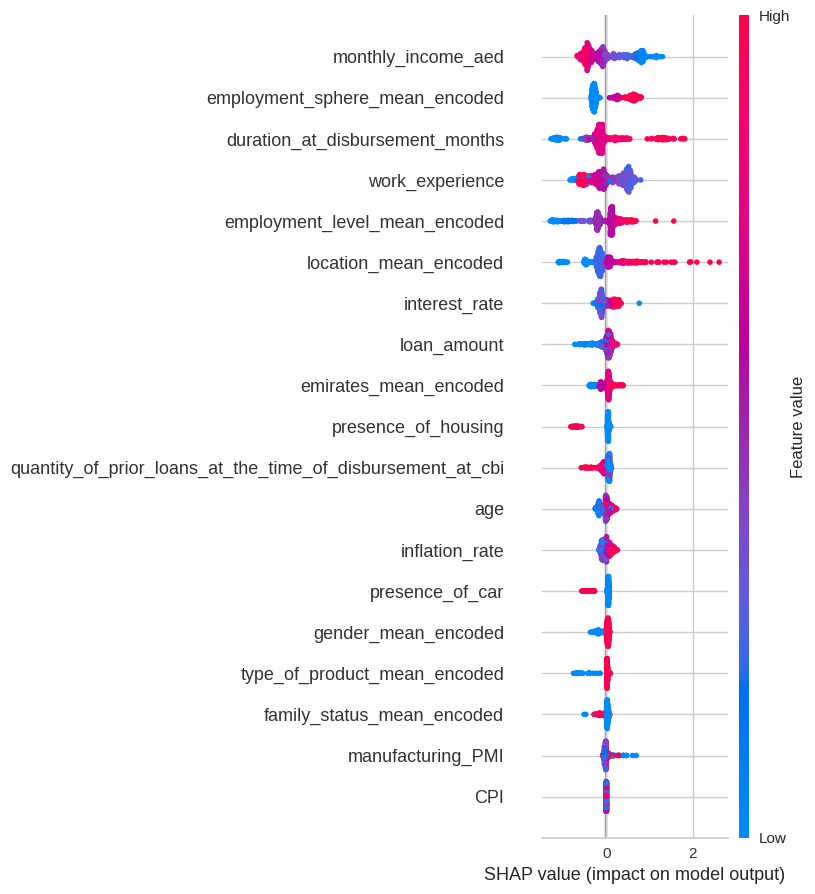

In [42]:
exp.interpret_model(trained_model_catboost)

In [173]:
blind = pd.read_excel('data/blind_set_new.xlsx')
blind.head()

,Client ID,Loan currency,Loan amount,Date of disbursement,Date of closure based on contract,Duration at disbursement (months),Interest rate,Max DPD - 3 year,Cumulative days of late payments throughout loan repayments,Quantity of prior loans (at the time of disbursement at CBI),...,Education level,Employment sphere,Employment level,Work experience,Presence of car,Presence of housing,Co-borrower,Collateral,Top Up,DSR
0,5297,AED,566060.30,2022-11-01,2031-10-27,108,0.050,4,8,4,...,NaN,Personal salary,SUPPORTING SERVICES TO AIR TRANSPORT,15 Years 0 Months,0,0,No,No,Yes,NaN
1,5298,AED,346000.00,2018-07-19,2022-08-01,49,0.000,396,518,1,...,NaN,Personal (Non business),MANAGER,10 Years 5 Months,0,0,No,No,Yes,49.06
2,5299,AED,78610.00,2017-10-17,2021-11-01,48,0.110,1461,1461,0,...,NaN,Personal (Non business),EXECUTIVE,12 Years -2 Months,0,0,No,No,No,48.67
3,4933,AED,216000.00,2018-01-08,2023-04-25,64,0.000,1009,1193,8,...,NaN,Personal others,OTHER BUSINESSES - OTHER THAN LISTED,22 Years 7 Months,1,0,No,No,No,NaN
4,5300,AED,90437.06,2018-07-19,2023-01-01,54,0.065,59,92,5,...,NaN,Personal salary,OTHERS,7 Years 7 Months,0,0,No,No,Yes,NaN


In [174]:
blind.rename(columns={
    'Client ID': 'client_id', 
    'Loan currency': 'loan_currency', 
    'Loan amount': 'loan_amount',
    'Date of disbursement': 'date_of_disbursement', 
    'Date of closure based on contract':'date_of_closure_based_on_contract', 
    'Duration at disbursement (months)': 'duration_at_disbursement_months',
    'Interest rate': 'interest_rate',
    'Max DPD - 3 year': 'max_dpd_3_year',
    'Cumulative days of late payments throughout loan repayments': 'cumulative_days_of_late_payments_throughout_loan_repayments',
    'Quantity of prior loans (at the time of disbursement at CBI)': 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
    'Type of product': 'type_of_product',
    'Status of loan': 'status_of_loan',
    'Location': 'location',
    'Emirates': 'emirates',
    'Gender': 'gender',
    'Age': 'age',
    'Family status': 'family_status',
    'Monthly income (AED)': 'monthly_income_aed',
    'Quantity of prior loans at CBI': 'quantity_of_prior_loans_at_cbi',
    'Employment sphere': 'employment_sphere',
    'Employment level': 'employment_level',
    'Work experience': 'work_experience',
    'Presence of car': 'presence_of_car',
    'Presence of housing': 'presence_of_housing',
    'Co-borrower': 'coborrower',
    'Collateral': 'collateral',
    'Top Up': 'top_up',
    'DSR': 'dsr'
    }, inplace=True)

In [175]:
blind.drop(columns=['Education level', "Quantity of client's dependents", 'loan_currency'], inplace=True)

In [176]:
blind.to_excel('index.xlsx', index=False)

In [177]:
# Adding monthly Macro-variables #
macro = pd.read_excel('data/UAE_Monthly1.xlsx')
macro['DateTime'] = macro['DateTime'].astype('datetime64')

blind['inflation_rate'] = np.zeros(len(blind))
blind['manufacturing_PMI'] = np.zeros(len(blind))

for i in blind.index:
    for j in macro.index:
        if blind.loc[i, 'date_of_disbursement'].year == macro.loc[j, 'DateTime'].year and blind.loc[i, 'date_of_disbursement'].month == macro.loc[j, 'DateTime'].month:
            blind.at[i, 'inflation_rate']    = macro.loc[j, 'Inflation Rate']
            blind.at[i, 'manufacturing_PMI'] = macro.loc[j, 'Manufacturing PMI']
            break

In [178]:
# Adding quarterly Macro-variables #
macro2 = pd.read_excel('data/UAE_quarter1.xlsx')
macro2['DateTime'] = macro2['DateTime'].astype('datetime64')

blind['CPI'] = [ np.nan for i in blind.index]

for i in blind.index:
    for j in macro2.index:
        if blind.loc[i, 'date_of_disbursement'].year == macro2.loc[j, 'DateTime'].year and blind.loc[i, 'date_of_disbursement'].month == macro2.loc[j, 'DateTime'].month:
            blind.at[i, 'CPI'] = macro2.loc[j, 'Consumer Price Index CPI']
            break

In [179]:
blind_macro = blind.copy()

In [180]:
def isnan(num):
    return num != num

# Converting Work experience feature to the months #
for i in blind_macro.index:
    it = blind_macro.loc[i, 'work_experience']
    years, months, gap, minus = 0, 0, False, False

    if isnan(it):
        continue
    
    # Extracting year and month from the string #
    for j in it :
        if j >= '0' and j <= '9' :
            if not gap :
                years = years*10 + int(j)
            else :
                months = months*10 + int(j)
        elif j == '-' :
            minus = True
            gap = True
        else :
            gap = True
    # Setting the new value to the DataFrame #
    if minus :
        months *= -1
        
    blind_macro.at[i, 'work_experience'] = int(years*12 + months)
    
blind_macro['work_experience'] = blind_macro['work_experience'].astype('float32')

In [181]:
# Target mean encoding #
cols = cat_feats


for col in cols:
    # Рассчитываем статистику на обучающем наборе
    stats = train.groupby(train[col])[target].agg(['mean'])
    
    # Создаем новый mean-encoded признак в блайндсете test
    blind_macro[col+'_mean_encoded'] = blind_macro[col].map(stats['mean'])

In [182]:
# Removing classes that are in test set but not in train set #
for i in blind_macro.index :
    for col in cat_feats :
        if type(blind_macro[col+'_mean_encoded'][i]) == str:
            blind_macro.drop(i,inplace=True)
            break
        
# We move all categorical variables to numerical list #
for i in cat_feats:
    num_feats.extend( [i+'_mean_encoded'] )
    ignore_feats.extend([i])

# cat_feats.clear()

In [193]:
final_model = exp.finalize_model(calibrated_catboost)

In [194]:
# THRESHOLD TEST
results = pd.DataFrame(columns=['threshold', 'Accuracy', 'AUC', 'TN', 'FP', 'FN', 'TP'])
predictions_blind = exp.predict_model(calibrated_catboost, data=blind_macro, raw_score=True, encoded_labels=True)

for thres in [x / 100 for x in range(10, 31, 5)]:
    predictions_blind['prediction_label'] = (predictions_blind['prediction_score_1'] > 0.15).astype(int)
    
predictions_blind

,client_id,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,...,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded,prediction_label,prediction_score_0,prediction_score_1
0,5297,566060.312500,2022-11-01,2031-10-27,108,0.050,4,8,4,PERSONAL LOAN,...,0.220884,0.205479,0.194892,0.154460,0.205486,0.206442,NaN,1,0.2616,0.7384
1,5298,346000.000000,2018-07-19,2022-08-01,49,0.000,396,518,1,PERSONAL LOAN,...,0.191601,0.205479,0.194892,0.313761,0.205486,0.206442,0.184739,1,0.2385,0.7615
2,5299,78610.000000,2017-10-17,2021-11-01,48,0.110,1461,1461,0,PERSONAL LOAN,...,0.204013,0.205479,0.194892,0.313761,0.205486,0.206442,0.205882,1,0.3950,0.6050
3,4933,216000.000000,2018-01-08,2023-04-25,64,0.000,1009,1193,8,CAR LOAN,...,0.204013,0.182500,0.194892,0.204651,0.205486,0.107143,1.000000,1,0.0728,0.9272
4,5300,90437.062500,2018-07-19,2023-01-01,54,0.065,59,92,5,PERSONAL LOAN,...,0.201117,0.182500,0.242515,0.154460,0.205486,0.206442,0.162162,1,0.7021,0.2979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,5293,75000.000000,2017-10-10,2021-10-02,48,0.115,0,0,0,PERSONAL LOAN,...,0.147727,0.182500,0.242515,0.313761,0.205486,0.206442,0.080000,0,0.8775,0.1225
2644,5294,145000.000000,2018-04-02,2022-04-25,49,0.030,7,11,6,PERSONAL LOAN,...,0.204013,0.205479,0.242515,0.204651,0.205486,0.206442,0.162162,1,0.5457,0.4543
2645,5294,61949.078125,2019-10-21,2023-04-30,43,0.000,715,952,7,PERSONAL LOAN,...,0.204013,0.205479,0.242515,0.204651,0.205486,0.206442,0.162162,1,0.3784,0.6216
2646,5295,117045.890625,2018-11-27,2023-04-05,53,0.060,1152,1265,4,PERSONAL LOAN,...,0.191601,0.205479,0.194892,0.204651,0.205486,0.206442,0.184739,1,0.4049,0.5951


In [195]:
predictions_blind[predictions_blind['prediction_label'] ==0]

,client_id,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,...,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded,prediction_label,prediction_score_0,prediction_score_1
5,5302,5.134982e+04,2019-12-11,2021-11-30,24,0.067500,913,1038,3,PERSONAL LOAN,...,0.191601,0.205479,NaN,0.313761,0.205486,0.206442,0.184739,0,0.9175,0.0825
8,4954,2.048344e+04,2018-12-05,2020-07-12,20,0.080000,20,20,4,PERSONAL LOAN,...,0.204013,0.205479,0.194892,0.204651,0.205486,0.206442,0.162162,0,0.9287,0.0713
9,4959,1.200000e+05,2018-05-09,2022-07-25,50,0.060000,0,0,8,PERSONAL LOAN,...,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.000000,0,0.9354,0.0646
10,5306,1.410000e+06,2018-11-01,2038-11-05,240,0.029900,0,0,1,HOUSING LOAN,...,0.201117,0.205479,0.194892,0.154460,0.081081,0.093333,0.000000,0,0.9345,0.0655
11,4964,1.275000e+06,2022-08-04,2037-04-30,176,0.066498,1,2,11,HOUSING LOAN,...,0.204013,0.182500,0.194892,0.154460,0.081081,0.093333,0.184739,0,0.9224,0.0776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2640,5290,2.200000e+05,2019-08-25,2023-10-25,50,0.072500,0,0,6,PERSONAL LOAN,...,0.201117,0.182500,0.194892,0.313761,0.205486,0.206442,0.000000,0,0.9346,0.0654
2641,5290,5.000000e+05,2021-02-21,2025-03-25,49,0.030000,0,0,8,PERSONAL LOAN,...,0.201117,0.182500,0.194892,0.313761,0.205486,0.206442,0.000000,0,0.9323,0.0677
2642,5290,1.220722e+06,2021-03-03,2046-02-28,300,0.076498,2,5,9,HOUSING LOAN,...,0.201117,0.182500,0.194892,0.313761,0.081081,0.093333,0.000000,0,0.9299,0.0701
2643,5293,7.500000e+04,2017-10-10,2021-10-02,48,0.115000,0,0,0,PERSONAL LOAN,...,0.147727,0.182500,0.242515,0.313761,0.205486,0.206442,0.080000,0,0.8775,0.1225


In [192]:
predictions_blind['prediction_score_0'].to_csv('calibrated_catboost_pd.csv', index=None)

In [ ]:
train.columns

Index(['client_id', 'loan_amount', 'date_of_disbursement',
       'date_of_closure_based_on_contract', 'duration_at_disbursement_months',
       'interest_rate', 'max_dpd_3_year',
       'cumulative_days_of_late_payments_throughout_loan_repayments',
       'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
       'type_of_product', 'status_of_loan', 'location', 'emirates', 'gender',
       'age', 'family_status', 'monthly_income_aed',
       'quantity_of_prior_loans_at_cbi', 'employment_sphere',
       'employment_level', 'work_experience', 'presence_of_car',
       'presence_of_housing', 'coborrower', 'collateral', 'top_up', 'dsr',
       'inflation_rate', 'manufacturing_PMI', 'CPI', 'max_90_bad',
       'cmltv_90_bad', 'location_mean_encoded', 'emirates_mean_encoded',
       'gender_mean_encoded', 'family_status_mean_encoded',
       'employment_sphere_mean_encoded', 'collateral_mean_encoded',
       'type_of_product_mean_encoded', 'employment_level_mean_encoded'],
      d

### Check some variables of train and blind set

In [77]:
num_feats[:-8]

['loan_amount',
 'duration_at_disbursement_months',
 'interest_rate',
 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
 'age',
 'monthly_income_aed',
 'work_experience',
 'inflation_rate',
 'manufacturing_PMI',
 'presence_of_car',
 'presence_of_housing',
 'CPI',
 'location_mean_encoded',
 'emirates_mean_encoded',
 'gender_mean_encoded',
 'family_status_mean_encoded',
 'employment_sphere_mean_encoded',
 'collateral_mean_encoded',
 'type_of_product_mean_encoded',
 'employment_level_mean_encoded']

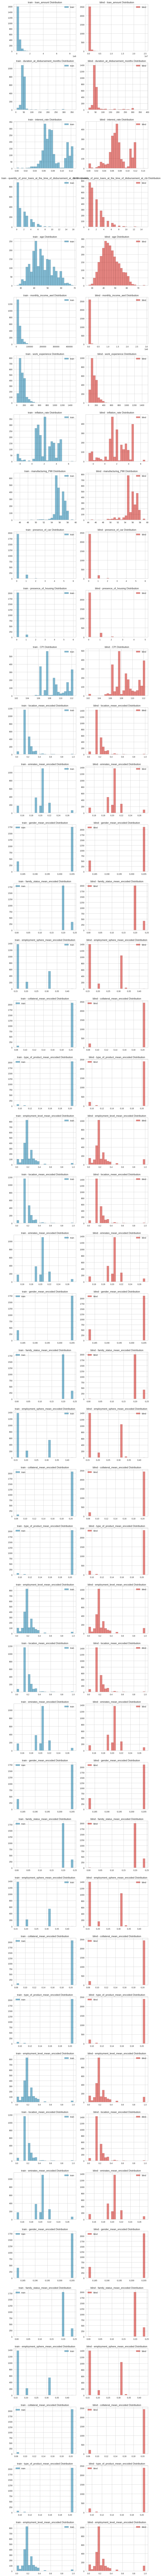

In [228]:
def compare_numeric_distributions(dataset1, dataset2, columns_to_compare):
    """
    Compare the distributions of numeric columns of two datasets using histograms.

    Args:
        dataset1 (pandas.DataFrame): The first dataset.
        dataset2 (pandas.DataFrame): The second dataset.
        columns_to_compare (list of str): A list of column names to compare.

    Returns:
        None
    """
    num_columns = len(columns_to_compare)
    fig, axes = plt.subplots(nrows=num_columns, ncols=2, figsize=(10, 4*num_columns))

    for i, column_name in enumerate(columns_to_compare):
        # Plot histogram for dataset1
        axes[i, 0].hist(dataset1[column_name], bins=25, alpha=0.5, color='b', label='train', edgecolor='k')
        axes[i, 0].set_title(f'train - {column_name} Distribution')
        axes[i, 0].legend()

        # Plot histogram for dataset2
        axes[i, 1].hist(dataset2[column_name], bins=25, alpha=0.5, color='r', label='blind', edgecolor='k')
        axes[i, 1].set_title(f'blind - {column_name} Distribution')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Example usage:

# Define the columns to compare
columns_to_compare = num_feats

# Call the compare_numeric_distributions method
compare_numeric_distributions(train, blind_macro, columns_to_compare)


In [79]:
print(train.shape)
print(test.shape)
print(blind_macro.shape)

(2152, 40)
(527, 40)
(2648, 41)


### Compare test and blind set

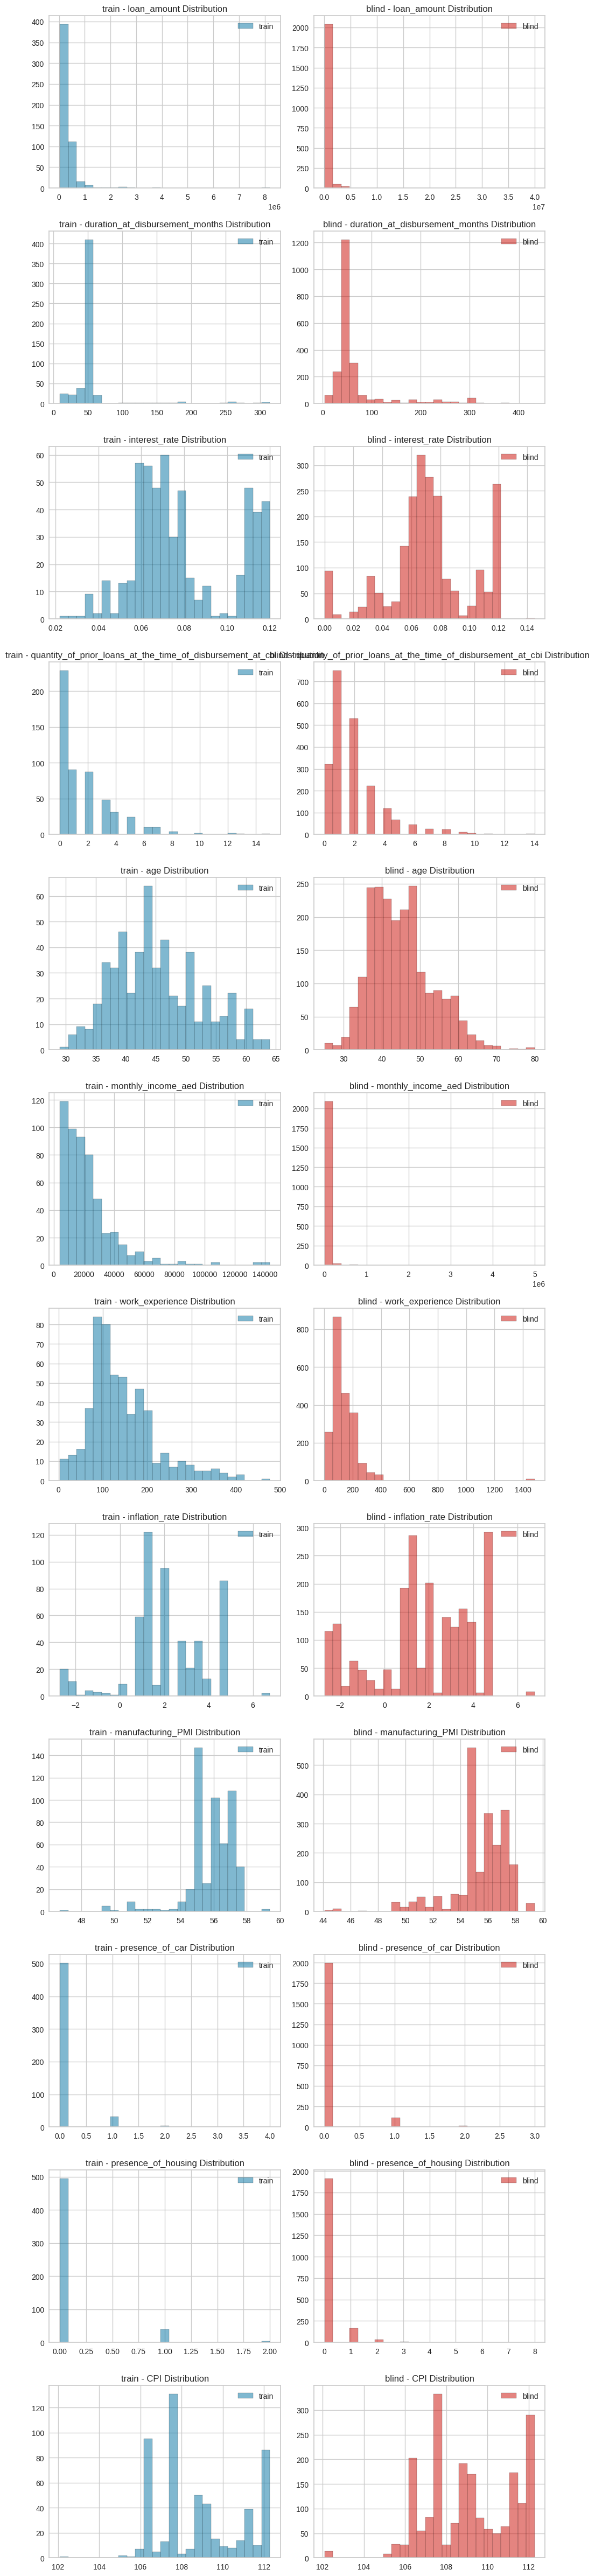

In [ ]:
compare_numeric_distributions(test, blind_macro, columns_to_compare)

In [80]:
# Summary statistics for dataset 1
summary_train= train[num_feats].describe()

# Summary statistics for dataset 2
summary_blind = blind_macro[num_feats].describe()

# Print summary statistics
print("Train Summary Statistics:")
summary_train

Train Summary Statistics:


,loan_amount,duration_at_disbursement_months,interest_rate,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,age,monthly_income_aed,work_experience,inflation_rate,manufacturing_PMI,presence_of_car,...,type_of_product_mean_encoded,employment_level_mean_encoded,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
count,2.152000e+03,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,...,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000,2152.000000
mean,2.988995e+05,53.352695,0.078748,1.673327,45.874535,22389.235841,148.009293,2.122756,55.987221,0.112918,...,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208,0.201208
std,3.859707e+05,34.477634,0.022750,2.057218,7.834531,20857.627160,86.204498,1.665606,1.233719,0.423376,...,0.023389,0.121472,0.102483,0.021384,0.008941,0.021857,0.069491,0.022674,0.023389,0.121472
min,1.500000e+04,6.000000,0.000000,0.000000,27.000000,3500.000000,3.000000,-2.500000,45.200000,0.000000,...,0.093333,0.000000,0.000000,0.147727,0.182500,0.000000,0.154460,0.081081,0.093333,0.000000
25%,1.250000e+05,48.000000,0.062500,0.000000,40.000000,10515.000000,93.000000,1.100000,55.100000,0.000000,...,0.206442,0.157434,0.158768,0.191601,0.205479,0.194892,0.154460,0.205486,0.206442,0.157434
50%,2.120000e+05,48.000000,0.072500,1.000000,45.000000,17500.000000,130.000000,2.100000,55.900000,0.000000,...,0.206442,0.184739,0.158768,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.184739
75%,3.642500e+05,52.000000,0.097000,3.000000,51.000000,26320.845000,189.250000,3.400000,57.000000,0.000000,...,0.206442,0.241379,0.231959,0.204771,0.205479,0.194892,0.313761,0.205486,0.206442,0.241379
max,8.508500e+06,358.000000,0.125000,16.000000,69.000000,429440.000000,1483.000000,6.770000,59.400000,6.000000,...,0.206442,1.000000,1.000000,0.272727,0.205479,0.242515,0.428571,0.205486,0.206442,1.000000


In [81]:
print("Blind Summary Statistics:")
summary_blind

Blind Summary Statistics:


,loan_amount,duration_at_disbursement_months,interest_rate,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,age,monthly_income_aed,work_experience,inflation_rate,manufacturing_PMI,presence_of_car,...,type_of_product_mean_encoded,employment_level_mean_encoded,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
count,2.648000e+03,2648.000000,2648.000000,2648.000000,2648.000000,2.648000e+03,2644.000000,2535.000000,2648.000000,2648.000000,...,2648.000000,2588.000000,2626.000000,2648.000000,2648.000000,2441.000000,2647.000000,2648.000000,2648.000000,2588.000000
mean,3.683086e+05,62.324396,0.075528,1.846299,45.607628,2.705271e+04,143.149399,1.985759,55.656495,0.100831,...,0.195817,0.225737,0.202282,0.202457,0.200941,0.201719,0.223021,0.195667,0.195817,0.225737
std,8.783541e+05,52.149426,0.026190,2.036357,7.788460,7.839220e+04,92.192322,1.983870,1.720808,0.391677,...,0.032666,0.190272,0.104392,0.020686,0.009150,0.023685,0.077346,0.033549,0.032666,0.190272
min,1.500000e+04,4.000000,0.000000,0.000000,27.000000,0.000000e+00,3.000000,-2.710000,44.100000,0.000000,...,0.093333,0.000000,0.000000,0.147727,0.182500,0.000000,0.154460,0.081081,0.093333,0.000000
25%,1.240878e+05,48.000000,0.062500,0.000000,40.000000,1.000000e+04,90.000000,1.100000,55.100000,0.000000,...,0.206442,0.157434,0.158768,0.201117,0.205479,0.194892,0.154460,0.205486,0.206442,0.157434
50%,2.130000e+05,48.000000,0.070000,1.000000,45.000000,1.730983e+04,124.000000,2.100000,55.900000,0.000000,...,0.206442,0.184739,0.158768,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.184739
75%,3.750000e+05,55.000000,0.087500,3.000000,51.000000,2.700000e+04,187.000000,3.500000,57.000000,0.000000,...,0.206442,0.241379,0.231959,0.204771,0.205479,0.194892,0.313761,0.205486,0.206442,0.241379
max,2.500000e+07,384.000000,0.145000,15.000000,76.000000,2.933226e+06,1483.000000,6.770000,59.400000,6.000000,...,0.206442,1.000000,1.000000,0.272727,0.205479,0.242515,0.428571,0.205486,0.206442,1.000000


In [130]:
from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp

# Example T-test
t_stat, p_value = ttest_ind(train['interest_rate'].dropna(), test['interest_rate'].dropna())
print("T-Test p-value:", f"{p_value:.10f}")

T-Test p-value: 0.0001645320


In [83]:
cat_feats

['location',
 'emirates',
 'gender',
 'family_status',
 'employment_sphere',
 'collateral',
 'type_of_product',
 'employment_level']

In [225]:
# Calculate Jaccard similarity
def jaccard_similarity_datasets(train, blind, cat_feats):
    comparings_two_cats = {}
    for categories in cat_feats:
        unique_categories1 = set(train[categories].unique())
        unique_categories2 = set(blind[categories].dropna().unique())

        intersection = len(unique_categories1.intersection(unique_categories2))
        union = len(unique_categories1.union(unique_categories2))

        jaccard_similarity = intersection / union
        comparings_two_cats[categories] = jaccard_similarity
    
    return comparings_two_cats


In [226]:
jaccard_similarity_datasets(train, blind_macro, cat_feats)

{'location': 0.75,
 'emirates': 1.0,
 'gender': 1.0,
 'family_status': 1.0,
 'employment_sphere': 0.8333333333333334,
 'collateral': 1.0,
 'type_of_product': 1.0,
 'employment_level': 0.7109375}

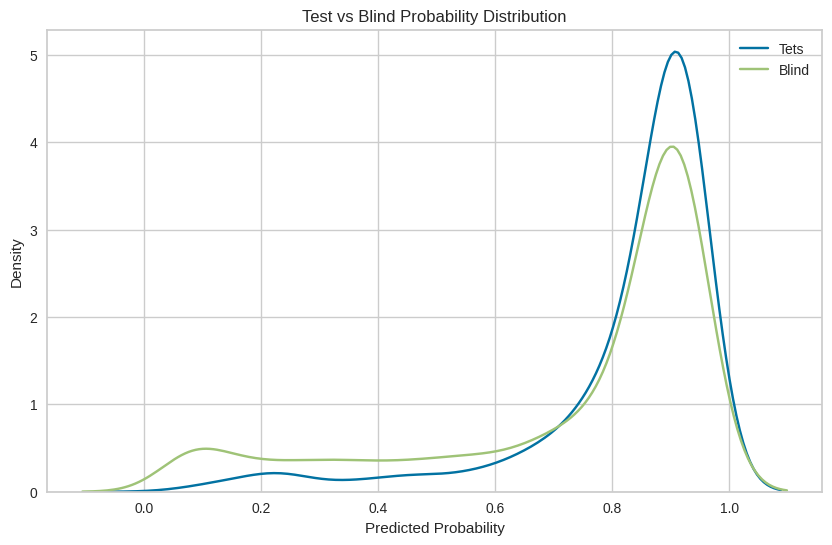

In [224]:

import seaborn as sns
# Plot the probability distribution for each class
plt.figure(figsize=(10, 6))

sns.distplot(predictions['prediction_score_0'], hist=False, label='Tets')
sns.distplot(predictions_blind['prediction_score_0'], hist=False, label='Blind')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Test vs Blind Probability Distribution')
plt.legend()
plt.show()

In [223]:
import scipy.stats as stats

def compare_datasets(train_data, blind_data, alpha=0.05):
    """
    Compare two datasets using the Kolmogorov-Smirnov test to determine if they come from the same distribution.

    Args:
        train_data (array-like): The first dataset (train data).
        blind_data (array-like): The second dataset (blind data).
        alpha (float): The significance level for the hypothesis test. Default is 0.05.

    Returns:
        bool: True if the datasets are likely to come from the same distribution, False otherwise.
    """
    # Perform the Kolmogorov-Smirnov test
    _, p_value = stats.ks_2samp(train_data, blind_data)
    
    # Compare the p-value to the significance level
    if p_value > alpha:
        return ("The datasets are likely from the same distribution.")
    else:
        return ("The datasets are likely from different distributions.") 


# train_data and blind_data are your actual datasets
compare_datasets(train['presence_of_housing'].values, blind['presence_of_housing'].values)

'The datasets are likely from different distributions.'

In [90]:
num_feats

['loan_amount',
 'duration_at_disbursement_months',
 'interest_rate',
 'quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi',
 'age',
 'monthly_income_aed',
 'work_experience',
 'inflation_rate',
 'manufacturing_PMI',
 'presence_of_car',
 'presence_of_housing',
 'CPI',
 'location_mean_encoded',
 'emirates_mean_encoded',
 'gender_mean_encoded',
 'family_status_mean_encoded',
 'employment_sphere_mean_encoded',
 'collateral_mean_encoded',
 'type_of_product_mean_encoded',
 'employment_level_mean_encoded',
 'location_mean_encoded',
 'emirates_mean_encoded',
 'gender_mean_encoded',
 'family_status_mean_encoded',
 'employment_sphere_mean_encoded',
 'collateral_mean_encoded',
 'type_of_product_mean_encoded',
 'employment_level_mean_encoded']

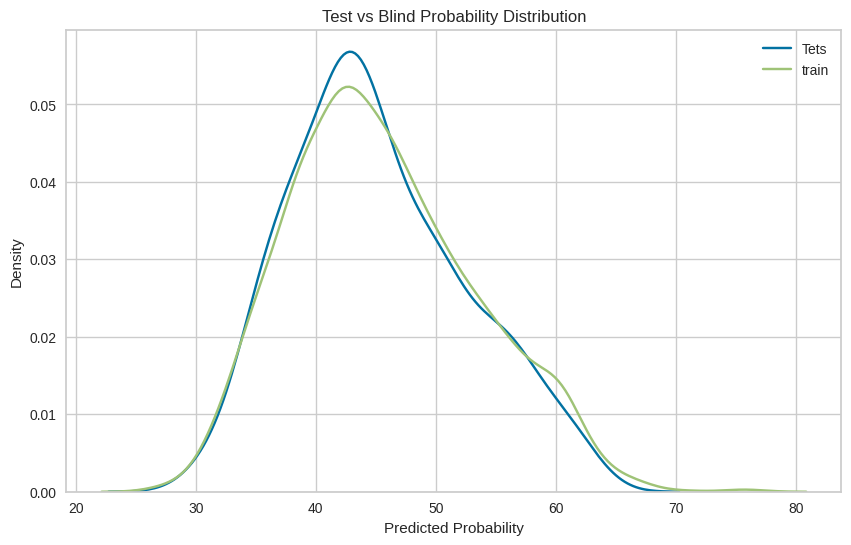

In [227]:

import seaborn as sns
# Plot the probability distribution for each class
plt.figure(figsize=(10, 6))

sns.distplot(test['age'], hist=False, label='Tets')
sns.distplot(blind['age'], hist=False, label='train')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Test vs Blind Probability Distribution')
plt.legend()
plt.show()

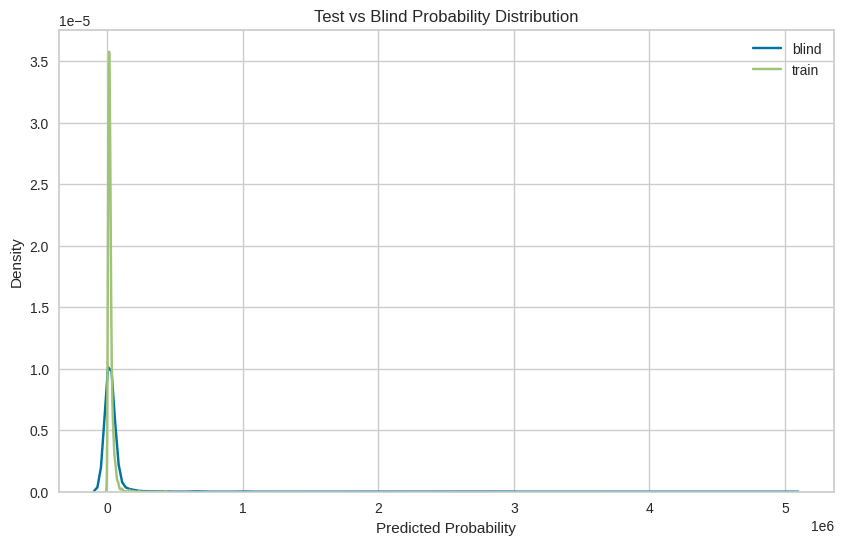

In [ ]:

import seaborn as sns
# Plot the probability distribution for each class
plt.figure(figsize=(10, 6))

sns.distplot(blind_macro['monthly_income_aed'], hist=False, label='blind')
sns.distplot(train['monthly_income_aed'], hist=False, label='train')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Test vs Blind Probability Distribution')
plt.legend()
plt.show()

In [98]:
train.drop_duplicates()

,client_id,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,...,max_90_bad,cmltv_90_bad,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
2921,8794,250000.0,2021-07-05,2025-08-01,49,0.0900,0,0,3,PERSONAL LOAN,...,0,0,0.231959,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.157434
1381,5622,217000.0,2017-08-03,2021-08-02,49,0.0800,0,0,6,PERSONAL LOAN,...,0,0,0.272727,0.147727,0.205479,0.194892,0.204651,0.205486,0.206442,0.163043
1600,5887,225000.0,2017-11-08,2020-11-26,36,0.0675,0,0,2,PERSONAL LOAN,...,0,0,0.158768,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.275510
1771,6096,100000.0,2017-12-13,2020-12-28,36,0.0675,0,0,2,PERSONAL LOAN,...,0,0,0.158768,0.204013,0.205479,0.194892,0.154460,0.205486,0.206442,0.277778
2486,9148,69500.0,2017-10-30,2021-11-28,48,0.1150,3,3,0,PERSONAL LOAN,...,0,0,0.158768,0.220884,0.205479,0.194892,0.154460,0.205486,0.206442,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,5942,350000.0,2017-09-25,2021-01-21,40,0.0625,0,0,4,PERSONAL LOAN,...,0,0,0.158768,0.220884,0.205479,0.194892,0.204651,0.205486,0.206442,0.184739
580,6386,200000.0,2017-10-15,2022-06-04,55,0.0750,939,939,1,PERSONAL LOAN,...,1,1,0.158768,0.204771,0.205479,0.242515,0.313761,0.205486,0.206442,0.162162
2028,6555,630000.0,2017-10-24,2022-02-04,52,0.0575,0,0,3,PERSONAL LOAN,...,0,0,0.000000,0.204771,0.205479,0.194892,0.313761,0.205486,0.206442,0.157434
1234,5464,245000.0,2018-02-12,2019-10-25,21,0.0650,0,0,3,PERSONAL LOAN,...,0,0,0.231959,0.204771,0.182500,0.194892,0.204651,0.205486,0.206442,0.184739


In [99]:
blind.drop_duplicates()

,client_id,loan_currency,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,...,work_experience,presence_of_car,presence_of_housing,coborrower,collateral,top_up,dsr,inflation_rate,manufacturing_PMI,CPI
0,5297,AED,566060.30,2022-11-01,2031-10-27,108,0.050,4,8,4,...,15 Years 0 Months,0,0,No,No,Yes,NaN,NaN,54.4,NaN
1,5298,AED,346000.00,2018-07-19,2022-08-01,49,0.000,396,518,1,...,10 Years 5 Months,0,0,No,No,Yes,49.06,3.80,55.8,111.40
2,5299,AED,78610.00,2017-10-17,2021-11-01,48,0.110,1461,1461,0,...,12 Years -2 Months,0,0,No,No,No,48.67,2.10,55.9,106.42
3,4933,AED,216000.00,2018-01-08,2023-04-25,64,0.000,1009,1193,8,...,22 Years 7 Months,1,0,No,No,No,NaN,4.80,56.8,112.29
4,5300,AED,90437.06,2018-07-19,2023-01-01,54,0.065,59,92,5,...,7 Years 7 Months,0,0,No,No,Yes,NaN,3.80,55.8,111.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,5293,AED,75000.00,2017-10-10,2021-10-02,48,0.115,0,0,0,...,7 Years 0 Months,0,0,No,No,No,28.02,2.10,55.9,106.42
2644,5294,AED,145000.00,2018-04-02,2022-04-25,49,0.030,7,11,6,...,12 Years 5 Months,0,0,No,No,Yes,NaN,3.50,55.1,107.36
2645,5294,AED,61949.08,2019-10-21,2023-04-30,43,0.000,715,952,7,...,12 Years 5 Months,0,0,No,No,Yes,NaN,-2.18,51.1,108.35
2646,5295,AED,117045.89,2018-11-27,2023-04-05,53,0.060,1152,1265,4,...,6 Years 5 Months,0,0,No,No,Yes,NaN,1.30,55.8,110.07


In [101]:
blind.shape

(2648, 33)

In [132]:
train.shape

(2152, 40)

In [148]:
train[train['client_id']==5293]

,client_id,loan_amount,date_of_disbursement,date_of_closure_based_on_contract,duration_at_disbursement_months,interest_rate,max_dpd_3_year,cumulative_days_of_late_payments_throughout_loan_repayments,quantity_of_prior_loans_at_the_time_of_disbursement_at_cbi,type_of_product,...,max_90_bad,cmltv_90_bad,location_mean_encoded,emirates_mean_encoded,gender_mean_encoded,family_status_mean_encoded,employment_sphere_mean_encoded,collateral_mean_encoded,type_of_product_mean_encoded,employment_level_mean_encoded
1094,5293,75000.0,2017-10-10,2021-10-02,48,0.115,0,0,0,PERSONAL LOAN,...,0,0,0.231959,0.147727,0.1825,0.242515,0.313761,0.205486,0.206442,0.08


In [139]:
blind['client_id']

0       5297
1       5298
2       5299
3       4933
4       5300
        ... 
2643    5293
2644    5294
2645    5294
2646    5295
2647    5296
Name: client_id, Length: 2648, dtype: int64